## Definições para o algoritmo

### Classe dos pontos do problema

In [273]:
class pontoIris:
    def __init__(self, id, largura, comprimento, especie):
        self.id = id
        self.comprimento = comprimento
        self.largura = largura
        self.especie = especie
        self.distancias = []

### Gerar pontos

In [274]:
# gera a lista de pontos de treinamento e teste
def gerar_conjunto_pontos(lista_ids, lista_larguras, lista_comprimentos, lista_especies):
    pontos = []

    numero_pontos = len(lista_ids)

    for i in range(numero_pontos):
        Id = lista_ids[i]
        comprimento = lista_comprimentos[i]
        largura = lista_larguras[i]
        especie = lista_especies[i]

        pontos.append(pontoIris(Id, largura, comprimento, especie))

    return pontos

### Funções de distância

In [275]:
import math

class Distancia:
    def euclidiana(A: pontoIris, B: pontoIris):
        diferenca_comprimento = A.comprimento - B.comprimento
        diferenca_largura = A.largura - B.largura

        return math.sqrt(diferenca_comprimento ** 2 + diferenca_largura ** 2)
    
    def manhattan(A: pontoIris, B: pontoIris):
        diferenca_comprimento = abs(A.comprimento - B.comprimento)
        diferenca_largura = abs(A.largura - B.largura)

        return diferenca_comprimento + diferenca_largura

    def minkowski(A: pontoIris, B: pontoIris, p: int = 2):
        diferenca_comprimento = abs(A.comprimento - B.comprimento) ** p
        diferenca_largura = abs(A.largura - B.largura) ** p

        return (diferenca_comprimento + diferenca_largura) ** (1 / p)

### Calcular distâncias do ponto atual para o conjunto total

In [276]:
def distancias_a_todos_pontos_treinamento(pontos_treinamento, ponto_teste):
    distancias = []
    
    for ponto_treinamento in pontos_treinamento:
        distancia = Distancia.euclidiana(ponto_teste, ponto_treinamento)

        distancias.append((distancia, ponto_treinamento))

    ponto_teste.distancias = sorted(distancias, key=lambda x: x[0])

## Implementação do algoritmo KNN

### Manipulação dos dados

#### Ler

In [277]:
import pandas as pd

caracteristicas = ["PetalWidthCm", "PetalLengthCm", "SepalWidthCm", "SepalLengthCm"]

# Lê o database
iris = pd.read_csv("./Iris.csv")

# Embaralha o database
iris = iris.sample(frac=1)

#### Separar os conjuntos (treinamento e teste)

In [278]:
tamanho_treinamento = round(len(iris) * 0.8)
treinamento = iris[:tamanho_treinamento].copy()
teste = iris[tamanho_treinamento:].copy()

#### Normalizar os dados

In [279]:
# Calcula a média e o desvio padrão com base apenas no conjunto de treinamento
media_treinamento = treinamento[caracteristicas].mean()
desvio_padrao_treinamento = treinamento[caracteristicas].std()

treinamento[caracteristicas] = (treinamento[caracteristicas] - media_treinamento) / desvio_padrao_treinamento #normaliza os dados de treino
teste[caracteristicas] = (teste[caracteristicas] - media_treinamento) / desvio_padrao_treinamento #normaliza os dados de teste

#### Gerar os pontos a serem analisados

In [280]:
# gera os pontos de treinamento com base no dataframe e guarda as distancias relativas de todos os pontos de treinamento com cada um desses pontos
pontos_treinamento = gerar_conjunto_pontos(
    treinamento["Id"].to_list(),
    treinamento["PetalWidthCm"].to_list(),
    treinamento["PetalLengthCm"].to_list(),
    treinamento["Species"].to_list(),
)

# gera os pontos de teste com base no dataframe e guarda as distancias relativas de todos os pontos de TREINAMENTO com cada um desses pontos
pontos_teste = gerar_conjunto_pontos(
    teste["Id"].to_list(),
    teste["PetalWidthCm"].to_list(),
    teste["PetalLengthCm"].to_list(),
    teste["Species"].to_list(),
)

### Analisar conjuntos

In [281]:
setosa = iris.loc[iris["Species"] == "Iris-setosa"]
virginica = iris.loc[iris["Species"] == "Iris-virginica"]
versicolor = iris.loc[iris["Species"] == "Iris-versicolor"]

#### Boxplots

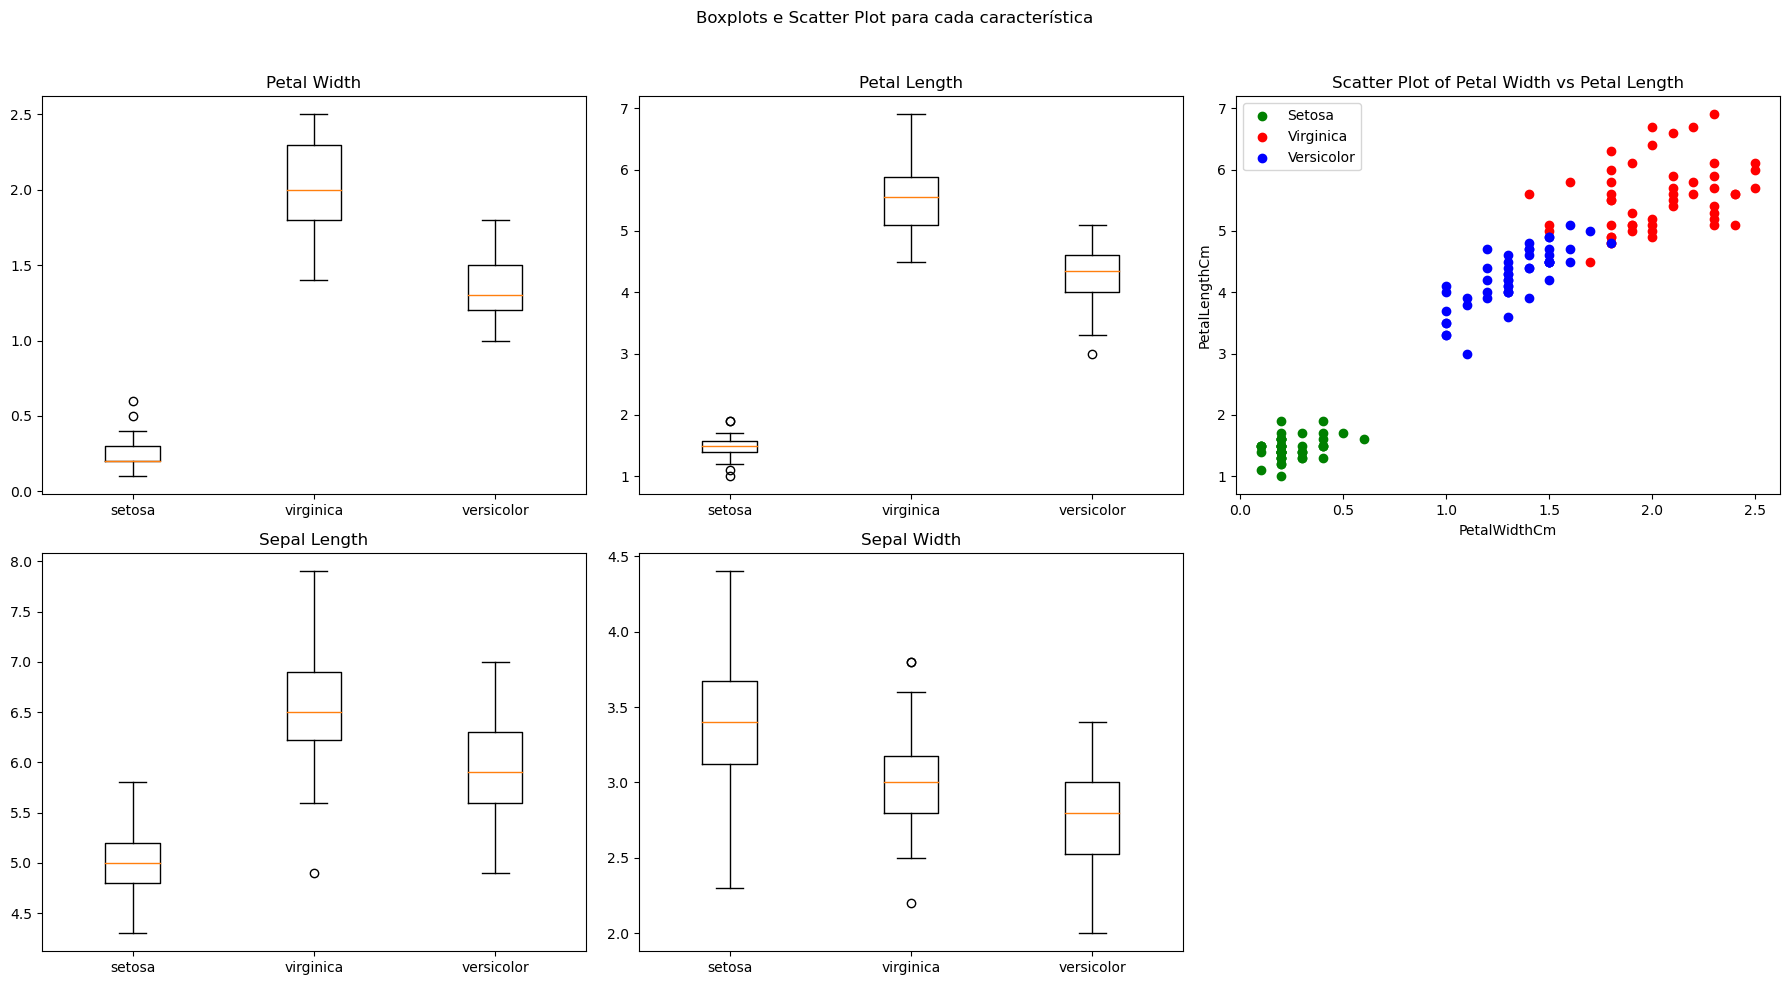

In [282]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Boxplots e Scatter Plot para cada característica")

# Boxplots
axs[0, 0].boxplot(
    [setosa["PetalWidthCm"], virginica["PetalWidthCm"], versicolor["PetalWidthCm"]],
    labels=["setosa", "virginica", "versicolor"],
)
axs[0, 0].set_title("Petal Width")

axs[0, 1].boxplot(
    [setosa["PetalLengthCm"], virginica["PetalLengthCm"], versicolor["PetalLengthCm"]],
    labels=["setosa", "virginica", "versicolor"],
)
axs[0, 1].set_title("Petal Length")

axs[1, 1].boxplot(
    [setosa["SepalWidthCm"], virginica["SepalWidthCm"], versicolor["SepalWidthCm"]],
    labels=["setosa", "virginica", "versicolor"],
)
axs[1, 1].set_title("Sepal Width")

axs[1, 0].boxplot(
    [setosa["SepalLengthCm"], virginica["SepalLengthCm"], versicolor["SepalLengthCm"]],
    labels=["setosa", "virginica", "versicolor"],
)
axs[1, 0].set_title("Sepal Length")

# Scatter plot
axs[0, 2].scatter(setosa["PetalWidthCm"], setosa["PetalLengthCm"], c="green", label="Setosa")
axs[0, 2].scatter(virginica["PetalWidthCm"], virginica["PetalLengthCm"], c="red", label="Virginica")
axs[0, 2].scatter(versicolor["PetalWidthCm"], versicolor["PetalLengthCm"], c="blue", label="Versicolor")
axs[0, 2].set_xlabel("PetalWidthCm")
axs[0, 2].set_ylabel("PetalLengthCm")
axs[0, 2].legend()
axs[0, 2].set_title("Scatter Plot of Petal Width vs Petal Length")

# Remove the empty subplot
fig.delaxes(axs[1, 2])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Algoritmo

#### Analisar todos os k's ímpares: [3, 120)

In [283]:
from collections import defaultdict

# valores_k = [i for i in range(1, len(pontos_treinamento)) if i % 2 != 0]  # valores de k a serem testados (impares)
valores_k = range(3, 120, 2)

precisao_por_k = {i: 0 for i in valores_k}

for k in valores_k:
    acertos = 0
    for ponto_teste in pontos_teste:
        distancias_a_todos_pontos_treinamento(pontos_treinamento, ponto_teste)
        vizinhos_mais_proximos = ponto_teste.distancias[:k]
        contagem_especies = defaultdict(int)

        for _, ponto in vizinhos_mais_proximos:
            contagem_especies[ponto.especie] += 1

        especie_mais_frequente = max(contagem_especies, key=contagem_especies.get)

        if especie_mais_frequente == ponto_teste.especie:
            acertos += 1
    precisao_por_k[k] = acertos / len(pontos_teste) * 100


#### Primeiro melhor k

In [284]:
melhor_k = max(precisao_por_k, key=precisao_por_k.get)
print(f"Melhor valor de k: {melhor_k}")
print(f"Melhor precisão: {precisao_por_k[melhor_k]}")

Melhor valor de k: 5
Melhor precisão: 100.0


### Gráfico de todos os k's

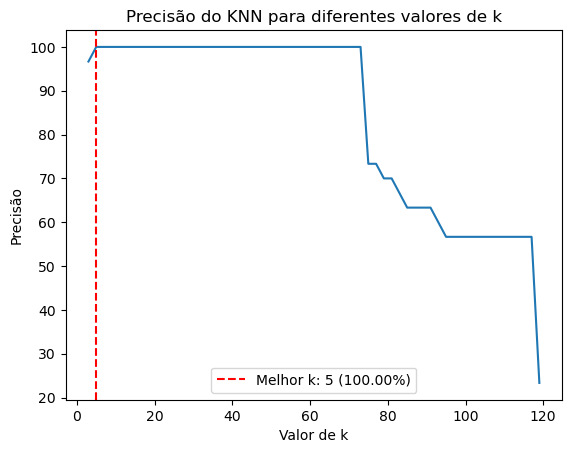

In [285]:
from matplotlib import pyplot as plt

plt.plot(precisao_por_k.keys(), precisao_por_k.values())
plt.xlabel("Valor de k")
plt.ylabel("Precisão")
plt.title("Precisão do KNN para diferentes valores de k")
plt.axvline(x=melhor_k, color='r', linestyle='--', label=f'Melhor k: {melhor_k} ({precisao_por_k[melhor_k]:.2f}%)')
plt.legend()
plt.show()